In [1]:
import pandas as pd 
import plotly. express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import warnings

In [2]:
warnings.filterwarnings('ignore') # ignore warnings

In [3]:
pd.options.display.max_rows = None # display all rows of dataframes

# Part 1: Exploratory Data Analysis and Data Preprocessing

In [4]:
data = pd.read_csv("Walmart_Store_sales.csv")
# it's easier to work with the columns when all their names are in lowercase
data.columns = data.columns.str.lower()

In [5]:
# in order not to read the file every time we need to reload the data
sales = data.copy()

## Displaying basic stats about the dataset:

In [6]:
# Basic stats about the dataframe
print(f"Number of rows : {sales.shape[0]}")
print()

print("Basic info: ")
sales.info()
print()

print("Display of sales: ")
display(sales.head())
print()

print("Basics statistics: ")
data_desc = sales.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*sales.isnull().sum()/sales.shape[0]), columns=['% missing values']))

Number of rows : 150

Basic info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         150 non-null    float64
 1   date          132 non-null    object 
 2   weekly_sales  136 non-null    float64
 3   holiday_flag  138 non-null    float64
 4   temperature   132 non-null    float64
 5   fuel_price    136 non-null    float64
 6   cpi           138 non-null    float64
 7   unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB

Display of sales: 


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


,% missing values
store,0.0
date,12.0
weekly_sales,9.0
holiday_flag,8.0
temperature,12.0
fuel_price,9.0
cpi,8.0
unemployment,10.0


## Initial cleaning of the dataset:

We can already see that we have some missing values. Especially in our target variable 'weekly_sales'. Imputating target variables is not a good idea as it might bias the predicitions. We will drop the lines with the missing values.<br><br>
Also, some features appear to be numerical but doesn't possess any numerical value, such as the 'store' columns. These are unordinal values.

In [7]:
# based on the initial data exploration, I decided to change the type of the store, date and holiday flag columns
sales['store'] = sales['store'].astype('int').astype('category')
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales['holiday_flag'] = sales['holiday_flag'].astype('category')

In [8]:
# Drop null values in the target variable (weekly sales)
sales.dropna(subset=['weekly_sales'], inplace=True)

We decide to exploit the date feature by extracting the year, month, day and dayofweek features from it.<br><br>
In order to do that, we have to transform it to datetime format.

In [9]:
# Extracting additional features from the date column
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month 
sales['day'] = sales['date'].dt.day
sales['dayofweek'] = sales['date'].dt.day_of_week

We decide to get rid of outliers in the numerical features by applying a statistical formula:<br><br>
[X − 3σ, X + 3σ]

In [10]:
for col in ['temperature', 'fuel_price', 'cpi', 'unemployment']:
    sales = sales.loc[sales[col].between(sales[col].mean() - 3*sales[col].std(), sales[col].mean() + 3*sales[col].std())]

In [11]:
print("Percentage of missing values: ")
display(pd.DataFrame(np.round(100*sales.isnull().sum()/sales.shape[0]), columns=['% missing values']))

Percentage of missing values: 


,% missing values
store,0.0
date,11.0
weekly_sales,0.0
holiday_flag,11.0
temperature,0.0
fuel_price,0.0
cpi,0.0
unemployment,0.0
year,11.0
month,11.0


## Visualising our target variable and features:

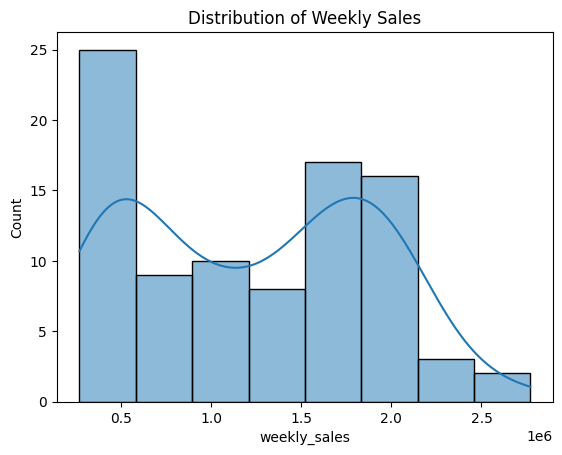

In [594]:
sns.histplot(sales['weekly_sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.show()

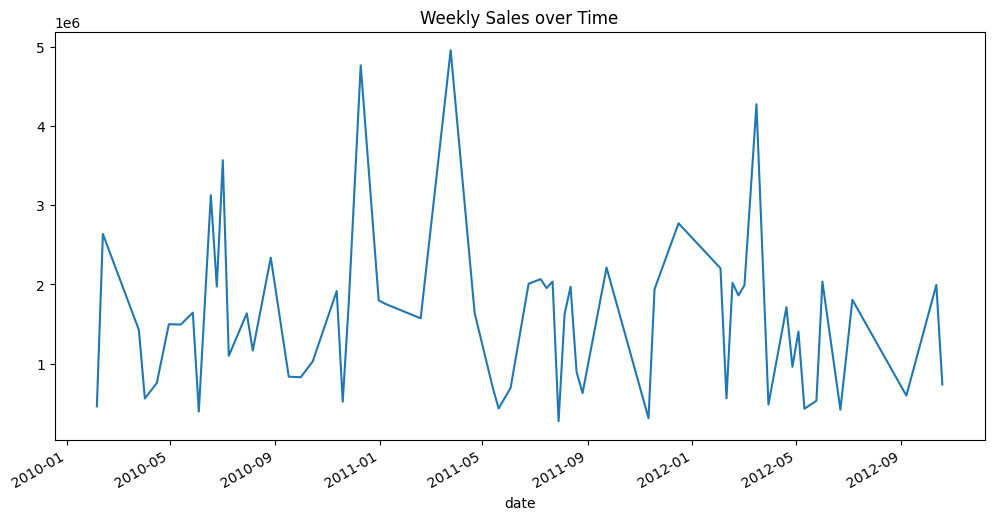

In [595]:
plt.figure(figsize=(12,6))
sales.groupby('date')['weekly_sales'].sum().plot()
plt.title('Weekly Sales over Time')
plt.show()

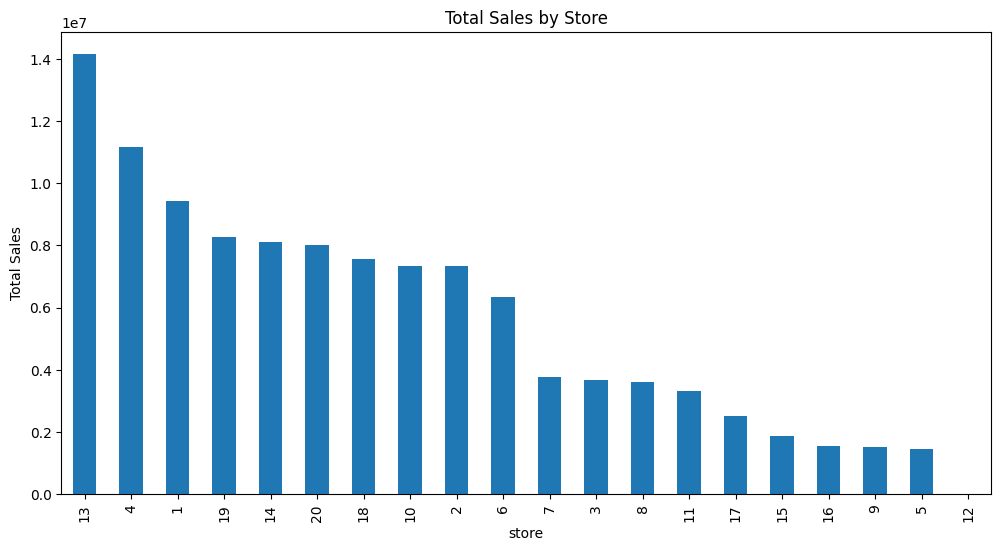

In [596]:
sales.groupby('store')['weekly_sales'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title('Total Sales by Store')
plt.ylabel('Total Sales')
plt.show()

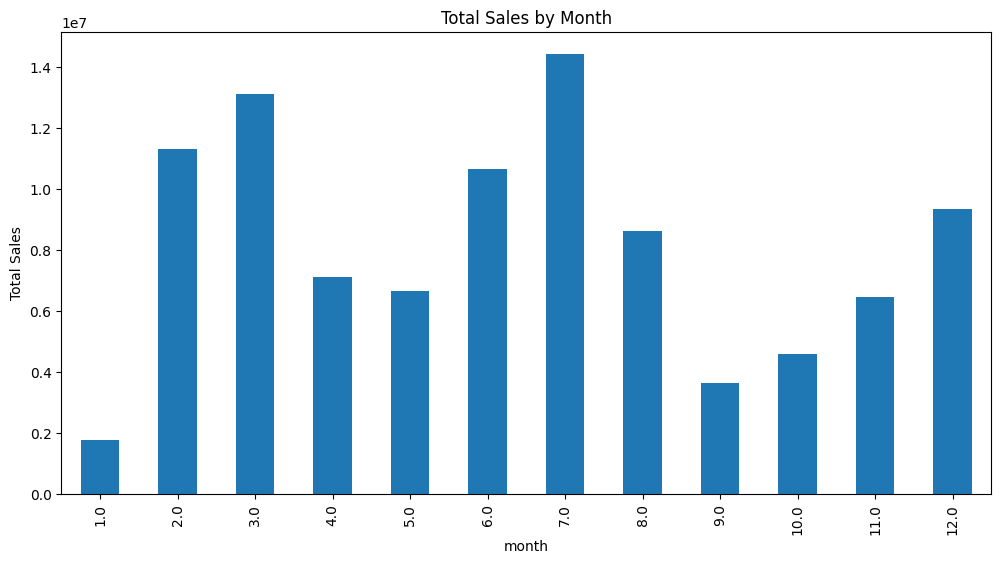

In [597]:
sales.groupby('month')['weekly_sales'].sum().plot(kind='bar', figsize=(12,6))
plt.title('Total Sales by Month')
plt.ylabel('Total Sales')
plt.show()

In [598]:
fig = px.box(sales, x='holiday_flag', y='weekly_sales')
fig.update_layout(title_text='Sales on Holidays vs Non-Holidays')
fig.show()

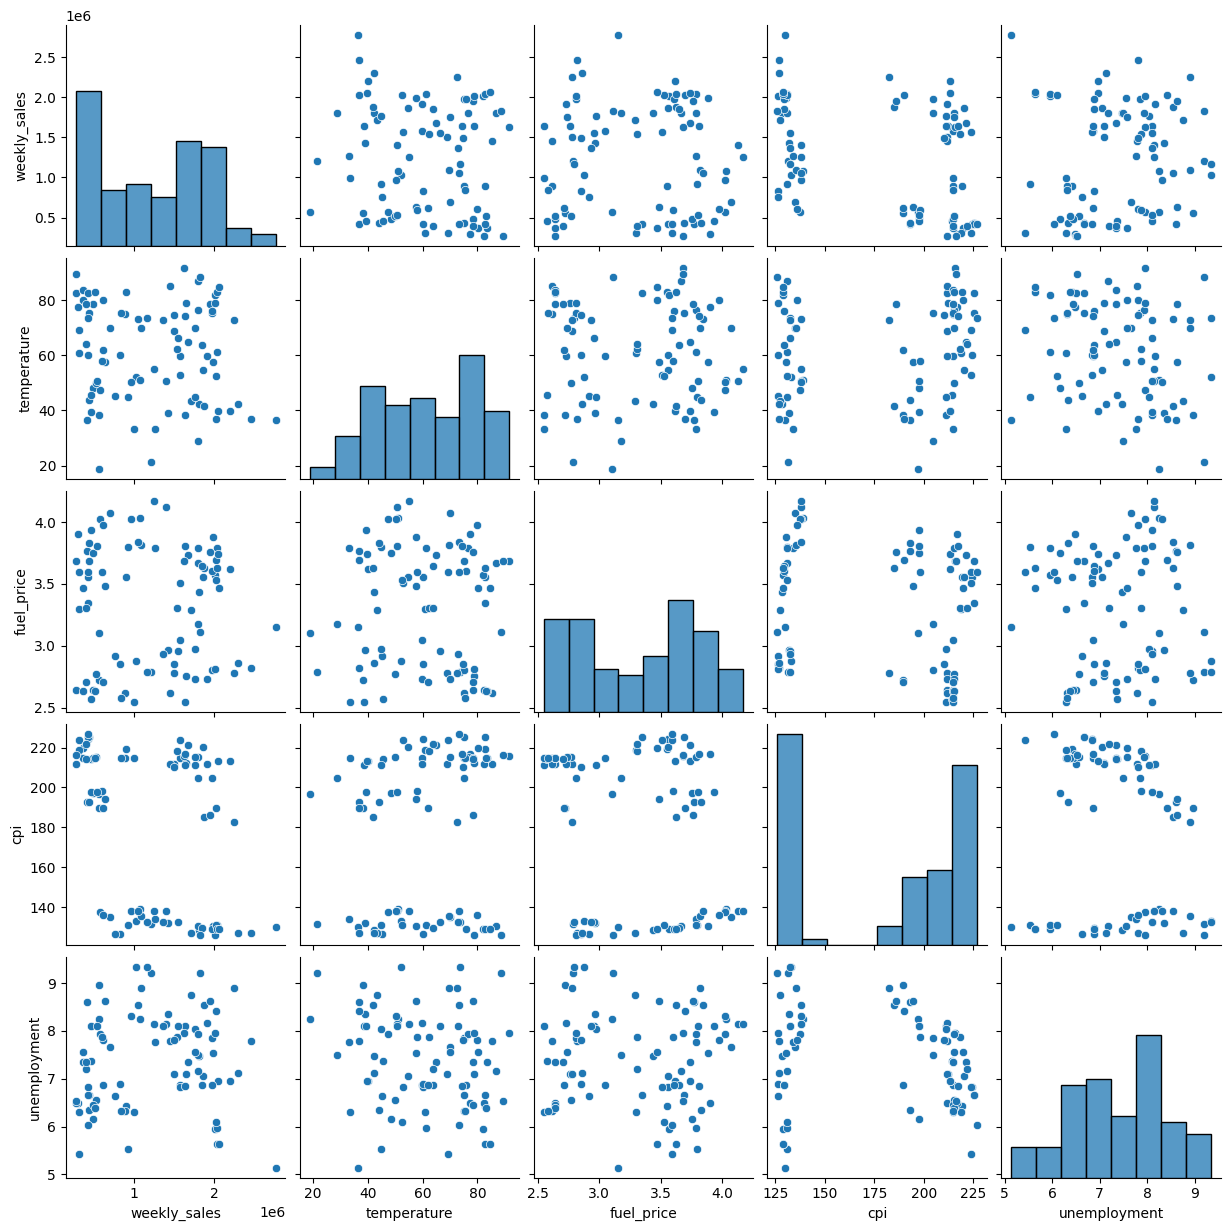

In [599]:
sns.pairplot(sales, vars=['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment'])
plt.show()

## Correlation Matrix:

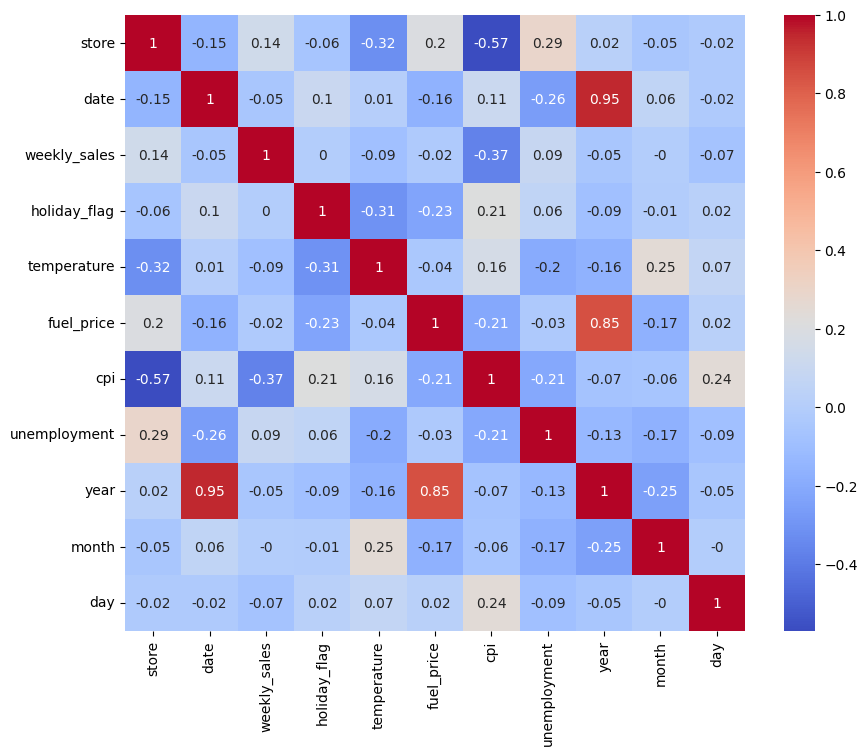

In [600]:
# Visualize correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(sales.drop('dayofweek', axis=1).corr().apply(axis=1, func=lambda x: np.round(x, 2)), annot=True, cmap='coolwarm')
plt.show()

After further analysis, we decided to drop the date column since we extracted the year, month and day elements from it.

In [601]:
sales.drop(['date'],axis=1, inplace=True)

## Data Preprocessing:

### Splitting our data between train and test sets:

In [602]:
target = 'weekly_sales'

X = sales.drop(target, axis=1)
Y = sales.loc[:,target] 

#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle=True)
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

### Separating numerical and categorical features:

In [603]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for index,type in X.dtypes.items():
    if ('float' in str(type)) or ('int' in str(type)) :
        numeric_features.append(index)
    else :
        categorical_features.append(index)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'day', 'dayofweek']
Found categorical features  ['store', 'holiday_flag']


### Building preprocessing pipelines and transforming our data:

In [604]:
# Adding imputers to preprocessing pipeline
num_pipeline = Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OneHotEncoder(drop='first'))])

# Update ColumnTransformer to use pipeline
transformer = [('cat', cat_pipeline, categorical_features), ('num', num_pipeline, numeric_features)]
preprocessor = ColumnTransformer(transformers=transformer)

# Preprocessings on train set
print("X_train before preprocessing: ")
display(X_train.head())
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print("X_train after preprocessing: ")
display(X_train)
print('preprocessings on train set...Done.')


# Preprocessings on test set
print("X_test before preprocessing: ")
display(X_test.head())
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !
print("X_test after preprocessing: ")
display(X_test)
print('preprocessings on test set...Done.')

Performing preprocessings on train set...
preprocessings on train set...Done.
Performing preprocessings on test set...
preprocessings on test set...Done.


# Part 2: Baseline model (Linear Regressor)

## Training the model:

We start by training a baseline linear regression model.

In [605]:
# Training a baseline linear regression model
print("Training a baseline linear regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
print("Training done.")
Y_train_pred = lr_model.predict(X_train)
Y_test_pred = lr_model.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark = pd.DataFrame({'model':['LinearRegression'], 'r2_train':[np.round(r2_train,3)], 'r2_test':[np.round(r2_test,3)], 'mae_train':[np.round(mae_train,0)], 'mae_test':[np.round(mae_test,0)], 'rmse_train':[np.round(rmse_train,0)], 'rmse_test':[np.round(rmse_test,0)]})
display(benchmark)

Training a baseline linear regression model...
Training done.


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.982,0.942,66872.0,108170.0,89558.0,138263.0


## Visualising feature importance:

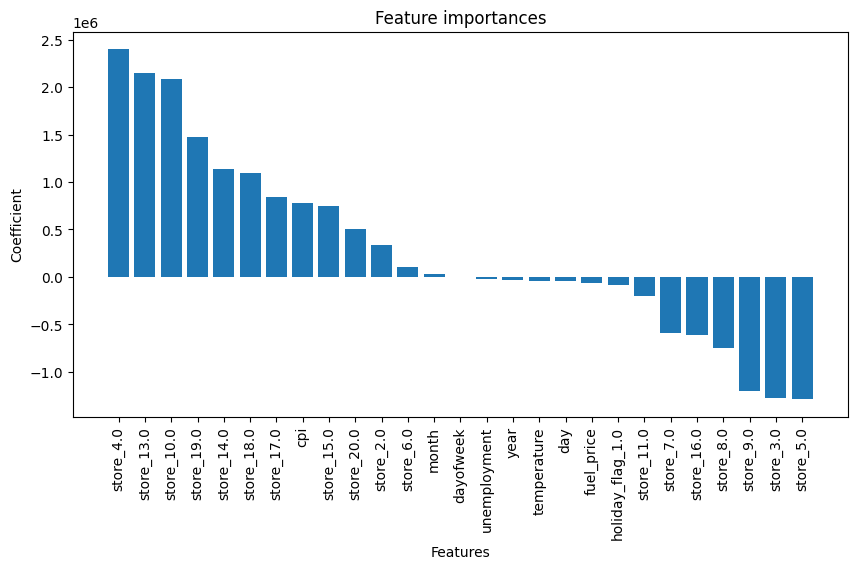

In [606]:
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
feature_names += numeric_features

# Extract coefficient values
coefs = lr_model.coef_
  
# Sort them and reverse (highest on top)
inds = np.argsort(coefs)[::-1]
sorted_coefs = coefs[inds]
sorted_features = np.array(feature_names)[inds]

# Take top 10
sorted_coefs_top10 = sorted_coefs[:10]
sorted_features_top10 = sorted_features[:10]

plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_coefs)
#plt.title('Top 10 feature importances')
plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

By looking at the feautre importances, we can see that the store in itself is by far the most important feature. However we won't be concluding anything for the time being.

# Part 3: Fight overfitting

**Even though the overfitting is minimal, we can maybe improve the results by using regularisation techniques like ridge, lasso and elasticnet.**

## Training a Ridge model with default parameters:

In [607]:
# Training a ridge model
print("Training a baseline linear regression model...")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, Y_train)
print("Training done.")
Y_train_pred = ridge_model.predict(X_train)
Y_test_pred = ridge_model.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark.loc[len(benchmark)] = ['Ridge Default',
                                  np.round(r2_train,3),
                                    np.round(r2_test,3),
                                      np.round(mae_train,0),
                                        np.round(mae_test,0),
                                          np.round(rmse_train,0),
                                            np.round(rmse_test,0)]
display(benchmark)

Training a baseline linear regression model...
Training done.


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.982,0.942,66872.0,108170.0,89558.0,138263.0
1,Ridge Default,0.925,0.872,144401.0,151954.0,183664.0,205480.0


## Training a Lasso model with default parameters:

In [608]:
# Training a lasso model
print("Training a baseline linear regression model...")
lasso_model = Lasso(alpha=1.0)  # alpha is the regularization strength
lasso_model.fit(X_train, Y_train)
print("Training done.")
Y_train_pred = lasso_model.predict(X_train)
Y_test_pred = lasso_model.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark.loc[len(benchmark)] = ['Lasso Default',
                                  np.round(r2_train,3),
                                    np.round(r2_test,3),
                                      np.round(mae_train,0),
                                        np.round(mae_test,0),
                                          np.round(rmse_train,0),
                                            np.round(rmse_test,0)]
display(benchmark)

Training a baseline linear regression model...
Training done.


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.982,0.942,66872.0,108170.0,89558.0,138263.0
1,Ridge Default,0.925,0.872,144401.0,151954.0,183664.0,205480.0
2,Lasso Default,0.982,0.948,68327.0,105720.0,90277.0,131175.0


## Training an ElasticNet model with default parameters:

In [609]:
# Training a elasticnet model
print("Training a baseline linear regression model...")
elastic_model = ElasticNet(alpha=1.0)  # alpha is the regularization strength
elastic_model.fit(X_train, Y_train)
print("Training done.")
Y_train_pred = elastic_model.predict(X_train)
Y_test_pred = elastic_model.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark.loc[len(benchmark)] = ['ElasticNet Default',
                                  np.round(r2_train,3),
                                    np.round(r2_test,3),
                                      np.round(mae_train,0),
                                        np.round(mae_test,0),
                                          np.round(rmse_train,0),
                                            np.round(rmse_test,0)]
display(benchmark)

Training a baseline linear regression model...
Training done.


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.982,0.942,66872.0,108170.0,89558.0,138263.0
1,Ridge Default,0.925,0.872,144401.0,151954.0,183664.0,205480.0
2,Lasso Default,0.982,0.948,68327.0,105720.0,90277.0,131175.0
3,ElasticNet Default,0.324,-0.085,503554.0,537806.0,552012.0,598799.0


# Part 4: Fine Tuning with GridSearchCV

**We decide to go even further and finetune our regularisation models using GridSearchCV**

## GridSearchCV with Ridge:

In [610]:
# Define the grid of hyperparameters
param_grid = {'alpha': [2, 5, 10, 100, 200, 230, 250,265, 270, 275, 290, 300, 500],
              'tol': [0.0001, 0.0005, 0.001, 0.01]}

# Initialize a GridSearchCV with 5-fold cross-validation for the Ridge model
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_grid_search.fit(X_train, Y_train)

Y_train_pred = ridge_grid_search.predict(X_train)
Y_test_pred = ridge_grid_search.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark.loc[len(benchmark)] = [f'Ridge {ridge_grid_search.best_params_}',
                                  np.round(r2_train,3),
                                    np.round(r2_test,3),
                                      np.round(mae_train,0),
                                        np.round(mae_test,0),
                                          np.round(rmse_train,0),
                                            np.round(rmse_test,0)]


## GridSearchCV with Lasso:

In [611]:
# Define the grid of hyperparameters
param_grid = {'alpha': [0.02, 0.024, 0.025, 0.026, 0.03, 1, 2, 5, 10, 100],
              'max_iter': [1000, 2000, 3000, 4000, 5000, 10000],
              'tol': [0.0001, 0.0005, 0.001, 0.01]}

# Repeat for the Lasso model
lasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_grid_search.fit(X_train, Y_train)

Y_train_pred = lasso_grid_search.predict(X_train)
Y_test_pred = lasso_grid_search.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark.loc[len(benchmark)] = [f'Lasso {lasso_grid_search.best_params_}',
                                  np.round(r2_train,3),
                                    np.round(r2_test,3),
                                      np.round(mae_train,0),
                                        np.round(mae_test,0),
                                          np.round(rmse_train,0),
                                            np.round(rmse_test,0)]

## GridSearchCV with ElasticNet:

In [612]:
# Define the grid of hyperparameters
param_grid = {'alpha': [0.02, 0.024, 0.025, 0.026, 0.03, 1, 2, 5, 10, 100],
              'max_iter': [1000, 2000, 3000, 4000, 5000, 10000],
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
              'tol': [0.0001, 0.0005, 0.001, 0.01]}

# Repeat for the ElasticNet model
elastic_grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5)
elastic_grid_search.fit(X_train, Y_train)

Y_train_pred = elastic_grid_search.predict(X_train)
Y_test_pred = elastic_grid_search.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark.loc[len(benchmark)] = [f'ElasticNet {lasso_grid_search.best_params_}',
                                  np.round(r2_train,3),
                                    np.round(r2_test,3),
                                      np.round(mae_train,0),
                                        np.round(mae_test,0),
                                          np.round(rmse_train,0),
                                            np.round(rmse_test,0)]

## Presenting the results:

In [613]:
display(benchmark.sort_values(by='r2_test', ascending=False))

,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
5,"Lasso {'alpha': 100, 'max_iter': 3000, 'tol': ...",0.982,0.951,69475.0,103520.0,91072.0,126803.0
2,Lasso Default,0.982,0.948,68327.0,105720.0,90277.0,131175.0
6,"ElasticNet {'alpha': 100, 'max_iter': 3000, 't...",0.977,0.948,75054.0,103972.0,101234.0,131210.0
0,LinearRegression,0.982,0.942,66872.0,108170.0,89558.0,138263.0
1,Ridge Default,0.925,0.872,144401.0,151954.0,183664.0,205480.0
4,"Ridge {'alpha': 2, 'tol': 0.0001}",0.855,0.740,214947.0,244540.0,256081.0,293125.0
3,ElasticNet Default,0.324,-0.085,503554.0,537806.0,552012.0,598799.0


Our finetuned lasso model got the best results. We can see that we reduced the overfitting to a minima.

## Feature importances for the best model:

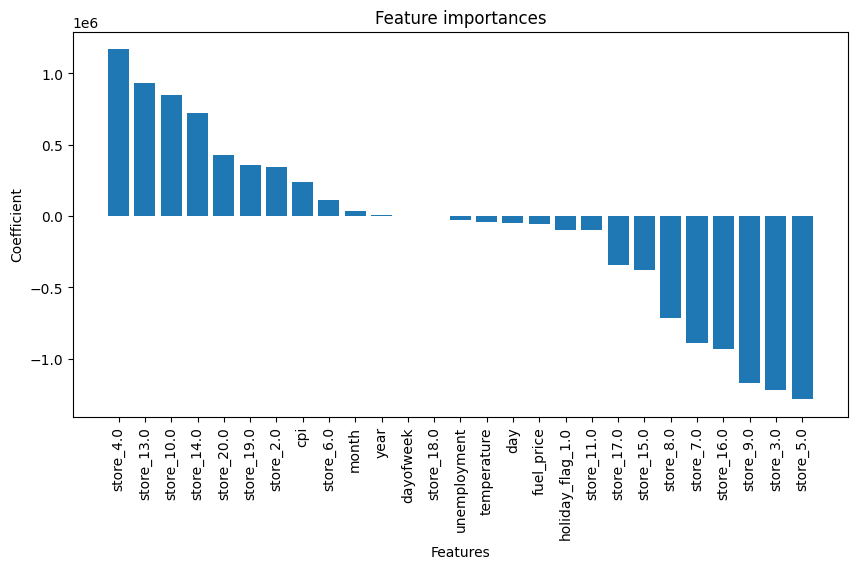

In [614]:
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
feature_names += numeric_features

# Extract coefficient values
coefs = lasso_grid_search.best_estimator_.coef_
  
# Sort them and reverse (highest on top)
inds = np.argsort(coefs)[::-1]
sorted_coefs = coefs[inds]
sorted_features = np.array(feature_names)[inds]
# Take top 10
sorted_coefs_top10 = sorted_coefs[:10]
sorted_features_top10 = sorted_features[:10]

plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_coefs)
#plt.title('Top 10 feature importances')
plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

# Part 5: Removing the store feature

Having just the store name as feature does not give us a great idea about what drive sales in retail. In order to be able to generalise, we need to get more info about the stores such as the location and the population surrounding it.<br><br> We noticed a large difference between some stores' weekly sales. <br><br>
We decided to remove the store feature, retrain the same models and analyse the results

Found numeric features  ['temperature', 'fuel_price', 'cpi', 'unemployment', 'year', 'month', 'day', 'dayofweek']
Found categorical features  ['holiday_flag']
Performing preprocessings on train set...
preprocessings on train set...Done.
Performing preprocessings on test set...
preprocessings on test set...Done.
Training a baseline linear regression model...
Training done.


,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
1,"Ridge {'alpha': 100, 'tol': 0.0001}",0.137,-0.207,572032.0,565588.0,623810.0,631416.0
3,"ElasticNet {'alpha': 2, 'l1_ratio': 0.7, 'max_...",0.181,-0.272,557132.0,583446.0,607864.0,648213.0
2,"Lasso {'alpha': 100, 'max_iter': 1000, 'tol': ...",0.219,-0.531,530834.0,620345.0,593499.0,711340.0
0,LinearRegression,0.219,-0.532,530746.0,620224.0,593499.0,711456.0


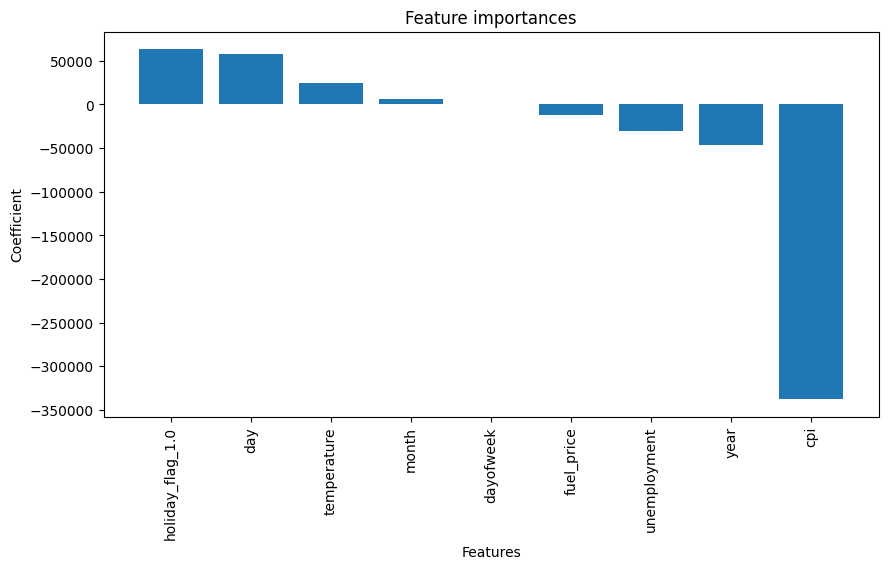

In [615]:
target = 'weekly_sales'
X = sales.drop([target, 'store'], axis=1)
Y = sales.loc[:,target] 
#Split the data into a train set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, shuffle=True)

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for index,type in X.dtypes.items():
    if ('float' in str(type)) or ('int' in str(type)) :
        numeric_features.append(index)
    else :
        categorical_features.append(index)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

# Adding imputers to preprocessing pipeline
num_pipeline = Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OneHotEncoder(drop='first'))])

# Update ColumnTransformer to use pipeline
transformer = [('cat', cat_pipeline, categorical_features), ('num', num_pipeline, numeric_features)]
preprocessor = ColumnTransformer(transformers=transformer)

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('preprocessings on train set...Done.')
# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !
print('preprocessings on test set...Done.')

# Training a baseline linear regression model
print("Training a baseline linear regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
print("Training done.")
Y_train_pred = lr_model.predict(X_train)
Y_test_pred = lr_model.predict(X_test)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)
mae_train = mean_absolute_error(Y_train, Y_train_pred)
mae_test = mean_absolute_error(Y_test, Y_test_pred)
rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
benchmark = pd.DataFrame({'model':['LinearRegression'],
                           'r2_train':[np.round(r2_train,3)],
                             'r2_test':[np.round(r2_test,3)],
                               'mae_train':[np.round(mae_train,0)],
                                 'mae_test':[np.round(mae_test,0)],
                                   'rmse_train':[np.round(rmse_train,0)],
                                     'rmse_test':[np.round(rmse_test,0)]})

# Define the grid of hyperparameters
param_grid = {'alpha': [2, 5, 10, 100, 200, 230, 250,265, 270, 275, 290, 300, 500],
              'tol': [0.0001, 0.0005, 0.001, 0.01]}

# Initialize a GridSearchCV with 5-fold cross-validation for the Ridge model
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_grid_search.fit(X_train, Y_train)

# Define the grid of hyperparameters
param_grid = {'alpha': [0.02, 0.024, 0.025, 0.026, 0.03, 1, 2, 5, 10, 100],
              'max_iter': [1000, 2000, 3000, 4000, 5000, 10000],
              'tol': [0.0001, 0.0005, 0.001, 0.01]}

# Repeat for the Lasso model
lasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_grid_search.fit(X_train, Y_train)

# Define the grid of hyperparameters
param_grid = {'alpha': [0.02, 0.024, 0.025, 0.026, 0.03, 1, 2, 5, 10, 100],
              'max_iter': [1000, 2000, 3000, 4000, 5000, 10000],
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
              'tol': [0.0001, 0.0005, 0.001, 0.01]}

# Repeat for the ElasticNet model
elastic_grid_search = GridSearchCV(ElasticNet(), param_grid, cv=5)
elastic_grid_search.fit(X_train, Y_train)

# Evaluate the performance of the models
regressors_list = [ridge_grid_search, lasso_grid_search, elastic_grid_search]
regressor_names = ['Ridge', 'Lasso', 'ElasticNet']
for regressor,name in zip(regressors_list, regressor_names):
  Y_train_pred = regressor.predict(X_train)
  Y_test_pred = regressor.predict(X_test)
  r2_train = r2_score(Y_train, Y_train_pred)
  r2_test = r2_score(Y_test, Y_test_pred)
  mae_train = mean_absolute_error(Y_train, Y_train_pred)
  mae_test = mean_absolute_error(Y_test, Y_test_pred)
  rmse_train = sqrt(mean_squared_error(Y_train, Y_train_pred))
  rmse_test = sqrt(mean_squared_error(Y_test, Y_test_pred))
  benchmark.loc[len(benchmark)] = [f'{name} {regressor.best_params_}',
                                    np.round(r2_train,3),
                                      np.round(r2_test,3),
                                        np.round(mae_train,0),
                                          np.round(mae_test,0),
                                            np.round(rmse_train,0),
                                              np.round(rmse_test,0)]

display(benchmark.sort_values(by='r2_test', ascending=False))
feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
feature_names += numeric_features

# Extract coefficient values
coefs = lasso_grid_search.best_estimator_.coef_
  
# Sort them and reverse (highest on top)
inds = np.argsort(coefs)[::-1]
sorted_coefs = coefs[inds]
sorted_features = np.array(feature_names)[inds]
# Take top 10
sorted_coefs_top10 = sorted_coefs[:10]
sorted_features_top10 = sorted_features[:10]

plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_coefs)
#plt.title('Top 10 feature importances')
plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.show()

As expected, removing the store feature, impacts the models' performances heavily. 

# Conclusion

To conclude, we build a prediction model that predicts weekly sales of Walmart stores. We trained multiple regression models. We applied regularization techniques to reduce overfitting and improve the model's performance. Our best estimator was a fine tuned Lasso regressor. Removing the 'store' feature impacts the model's performance heavily. <br><br>However, in order to generalise the model, more data concerning the store's area of operation, the consumers and the working habits of each store might help produce a robust model.